### Load packages

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(msigdbr)
library(ComplexHeatmap)
library(circlize)
library(Seurat)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.16
CRAN page: https://cran.r-project.org/package

### Load data and genes

In [43]:
load("SeuratData_DEGs.RData")

In [44]:
meta_genes <- read.csv('Metabolic_DEGs_Updated.csv') %>%
    filter(role %in% c('OXPHOS','TCA Cycle', 'Glycolysis'))
head(meta_genes)

,gene_symbol,role,direction,all,ilc1,ilc2,ilc3
,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>
1,Tfam,OXPHOS,up,TRUE,TRUE,FALSE,FALSE
2,Mdh1,TCA Cycle,up,TRUE,TRUE,TRUE,FALSE
3,Sdhb,TCA Cycle,up,TRUE,TRUE,FALSE,FALSE
4,Suclg1,TCA Cycle,up,TRUE,FALSE,TRUE,FALSE
5,Cycs,OXPHOS,up,TRUE,FALSE,TRUE,TRUE
6,Pgam1,Glycolysis,up,TRUE,FALSE,FALSE,FALSE


### Get DEGs

In [45]:
deg$source <- "all"
deg1$source <- "ilc1"
deg2$source <- "ilc2"
deg3$source <- "ilc3"

# Combine all data frames into one
meta_deg_df <- bind_rows(deg, deg1, deg2, deg3) %>% filter(gene_symbol %in% meta_genes$gene_symbol)
meta_deg_df$gene_symbol %>% unique %>% length

[1] 26

### Get Genes and Roles

In [54]:
up <- meta_genes %>% filter(direction == "up")
DefaultAssay(dat) <- "RNA"
Idents(dat) <- dat@meta.data$sample
genes2plot <- up %>% arrange(role, gene_symbol) %>% pull(gene_symbol) %>% unique %>% rev

In [55]:
roles <- up$role %>% stringr::str_wrap(width = 10)
names(roles) <- up$gene_symbol 
roles 

Tfam         Mdh1         Sdhb       Suclg1         Cycs        Pgam1 
    "OXPHOS"  "TCA Cycle"  "TCA Cycle"  "TCA Cycle"     "OXPHOS" "Glycolysis" 
        Tpi1         Pgk1       Uqcrc1         Etfb       Cox7a2         Eno1 
"Glycolysis" "Glycolysis"     "OXPHOS"     "OXPHOS"     "OXPHOS" "Glycolysis" 
      Uqcrc2          Pkm          Me2        Gapdh       Ndufa1       Cox4i1 
    "OXPHOS" "Glycolysis"  "TCA Cycle" "Glycolysis"     "OXPHOS"     "OXPHOS" 
        Mdh2         Ldha         Fth1        Aldoa         Gpi1         Ucp2 
 "TCA Cycle" "Glycolysis"  "TCA Cycle" "Glycolysis" "Glycolysis"     "OXPHOS"

### Dotplot

Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


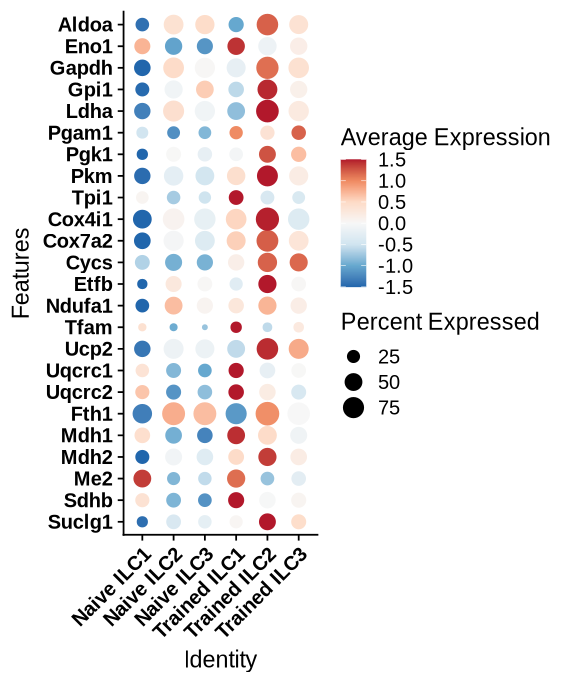

In [61]:
options(repr.plot.width = 4.7, repr.plot.height = 5.7)
DotPlot(object = dat, features = genes2plot, cols="RdBu", col.max = 1.5, col.min = -1.5) + scale_size(range = c(1, 6)) + coord_flip() +
    scale_y_discrete(labels = c(
        "mILC1_control" = "Naive ILC1", 
        "mILC1_treatment" = "Trained ILC1", 
        "mILC2_control" = "Naive ILC2", 
        "mILC2_treatment" = "Trained ILC2",  
        "mILC3_control" = "Naive ILC3", 
        "mILC3_treatment" = "Trained ILC3")) + 
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, face = "bold"), 
        axis.text.y = element_text(face = "bold", size = 12),
        legend.position = "right", 
        legend.box = "vertical")

### Heatmap 

In [49]:
make_heatmap_with_roles <- function(seurat_object, genes_to_plot, font_size, hp_height, hp_width, roles){

    # heatmap : gene expression 
    p <- DotPlot(seurat_object, features = genes_to_plot, assay = "RNA", group.by = "sample")
    df <- p$data
    exp_mat <- df %>% dplyr::select(-pct.exp, -avg.exp) %>% tidyr::pivot_wider(names_from = id, values_from = avg.exp.scaled) %>% as.data.frame() 
    row.names(exp_mat) <- exp_mat$features.plot  
    exp_mat <- exp_mat[,-1] %>% as.matrix()
    exp_mat <- exp_mat %>% as.data.frame %>% 
        dplyr::select(mILC1_control, mILC2_control, mILC3_control, mILC1_treatment, mILC2_treatment, mILC3_treatment) %>% as.matrix()
    colnames(exp_mat) <- c('ILC1', 'ILC2', 'ILC3', 'ILC1 ', 'ILC2 ', 'ILC3 ')
    condition_split <- c('Naive', 'Naive', 'Naive', 'Trained', 'Trained', 'Trained')

    # top annotation with condition with labels
    condition_labels <- c('Naive', 'Naive', 'Naive', 'Trained', 'Trained', 'Trained')
    top_annotation <- HeatmapAnnotation(
        condition = anno_block(gp = gpar(fill = c('white', 'black')),
            labels = unique(condition_labels), 
            labels_gp = gpar(col = c('black', 'white'), fontsize = font_size - 1, fontface = "bold")))  # Set font color to black and white

    roles <- roles[rownames(exp_mat)]
    hp <- Heatmap(exp_mat,
        heatmap_legend_param=list(title = "Scaled\nExpression"),
        col = circlize::colorRamp2(c(-1.5,0,1.5), c('#000089', '#F7F7F7','#cc0000')),
        column_split = condition_split,
        row_split = roles,
        cluster_columns = FALSE,
        show_row_dend = FALSE,
        show_column_dend = FALSE,
        row_names_gp = gpar(fontsize = font_size - 1, fontface = "bold"), # gene names
        column_names_rot = 45, 
        column_names_gp = gpar(fontsize = font_size - 1, fontface = "bold"),
        row_names_side = "left",
        column_names_side = "bottom",
        column_title = NULL,
        row_title_gp = gpar(fontsize = font_size, fontface = "bold"),
        row_title_side = "right",
        row_title_rot = 0,
        heatmap_height = unit(hp_height, "cm"),
        heatmap_width = unit(hp_width, "cm"),
        top_annotation = top_annotation)
    return(hp)
}


In [53]:
up %>% arrange(role, gene_symbol)

gene_symbol,role,direction,all,ilc1,ilc2,ilc3
<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>
Aldoa,Glycolysis,up,FALSE,FALSE,TRUE,FALSE
Eno1,Glycolysis,up,TRUE,FALSE,FALSE,FALSE
Gapdh,Glycolysis,up,FALSE,TRUE,FALSE,FALSE
Gpi1,Glycolysis,up,FALSE,FALSE,TRUE,FALSE
Ldha,Glycolysis,up,FALSE,TRUE,TRUE,FALSE
Pgam1,Glycolysis,up,TRUE,FALSE,FALSE,FALSE
Pgk1,Glycolysis,up,TRUE,TRUE,TRUE,FALSE
Pkm,Glycolysis,up,TRUE,TRUE,TRUE,FALSE
Tpi1,Glycolysis,up,TRUE,TRUE,FALSE,FALSE


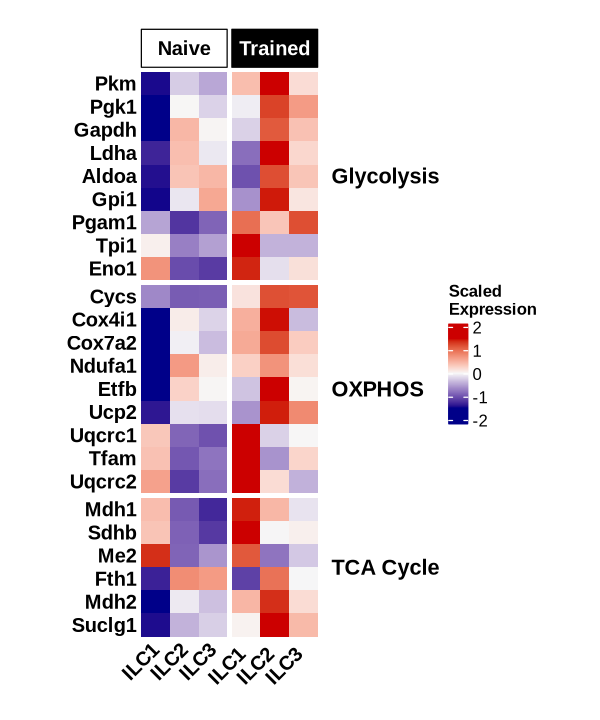

In [50]:
options(repr.plot.width = 5, repr.plot.height = 6)
hp <- make_heatmap_with_roles(dat, genes2plot, font_size = 13, hp_height = 14, hp_width = 8, roles)
draw(hp)